<h1>SBS - project II - demo</h1>

In [90]:
# importing Python libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sst

In [91]:
# INPUT
# I - large scale effects / empirical model
raw_data_I_rx = './SBS-PRJ2data_demo1.csv' # data representing equidistant measurement along a straight path
d_start = 1 # path starting point distance
d_end = 70 # poth end point distance
Fkonst = 58 # from power balance to extract the loss 
# II - smal scale effects
raw_data_II_rx = ['./SBS-PRJ2data_demo2.csv','./SBS-PRJ2data_demo3.csv'] # data files representing measurement for fixed antennas
raw_data_II_t = [35, 50] # duration i seconds for each file


<h2>I. Large Scale Effects / Empirical Model</h2>

974 readings


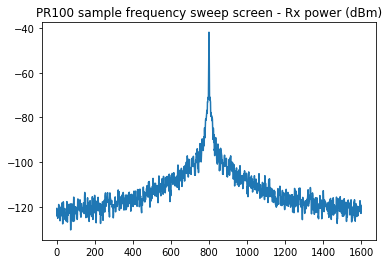

In [92]:
# Reading raw measurement data 
with open(raw_data_I_rx) as ff:
    rRX = ff.read().split() # each line = 1601 readings from the PR100 receiver screen
if d_start > d_end: # reverse the data so the distance would be encreasing
    rRx = [x for x in reversed(rRx)]
    d_start, d_end = d_end, d_start
print(len(rRX), 'readings')
screens_dBm = []
for line in rRX:
    screens_dBm.append( [float(x) for x in line.split(';')]   )
plt.figure()
plt.plot(screens_dBm[0])
plt.title('PR100 sample frequency sweep screen - Rx power (dBm)')
plt.show()

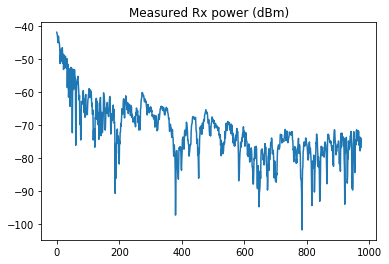

In [93]:
# extracting RX value from raw data as a maximum value of each sweep screen
Rx = [max(x) for x in screens_dBm]
plt.figure()
plt.plot(Rx)
plt.title('Measured Rx power (dBm)')
plt.show()

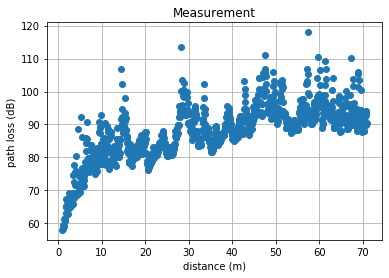

In [94]:
# generate distance and relative loss vectors
# - recording in constant speed between d_start (m) and d_end (m) considered
# - L normalized based on the power budget
d = np.array(range(len(Rx)))
d = d_start + d * d_end/len(d)
L = Rx[0] - np.array(Rx) + Fkonst
plt.figure()
plt.plot(d,L, 'o')
plt.title('Measurement')
plt.xlabel('distance (m)')
plt.grid()
plt.ylabel('path loss (dB)')
plt.show()

<h3>Illustration of the short-term fading elimination using the slide window averaging (running mean)</h3>

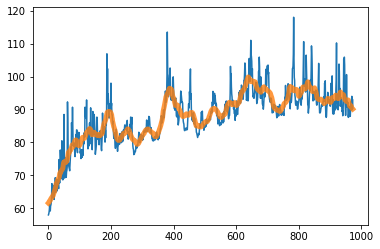

In [95]:
win=15 
Lf=[]
for i in range(len(L)):
    imin = max(0,i-win)
    imax = min(len(L),i+win)
    Lf.append(sum(L[j] for j in range(imin, imax))/(imax-imin))
plt.figure()
plt.plot(L)
plt.plot(Lf,lw=5,alpha=0.8)
plt.show()

<h2>Path-loss Modelling</h2>

<h3>One Slope Model fitting</h3>

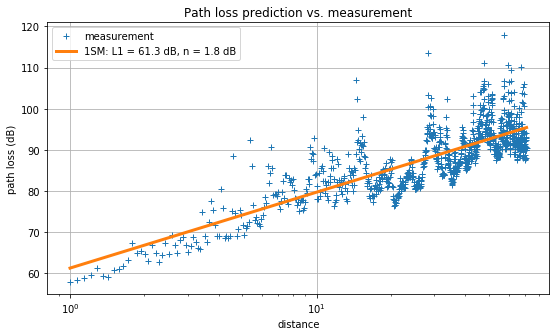

Empirical One Slope Model parameters:
L1 = 61.3 dB
n = 1.8
standard deviation = 5.1 dB
mean error = 3.9 dB


In [96]:
logd = np.log10(d)
n, L1, rv, pv, stderr = sst.linregress(logd, L)
Lp = L1 + n * logd # prediction by the derived model
# show plot
plt.figure(figsize=(9, 5))
plt.semilogx(d, L, '+', lw=0.1, label='measurement')
plt.semilogx(d, Lp, lw=3, label=f'1SM: L1 = {L1:.1f} dB, n = {0.1*n:.1f} dB')
plt.xlabel('distance')
plt.ylabel('path loss (dB)')
plt.title('Path loss prediction vs. measurement')
plt.legend()
plt.grid()
plt.show()
# calculate prediction error and print results
err = Lp-L
stdev = np.std(err)
print('Empirical One Slope Model parameters:')
print('L1 =', L1.round(1), 'dB')
print('n =', (0.1*n).round(1))
print('standard deviation =', stdev.round(1), 'dB')
print('mean error =', np.mean(np.abs(err)).round(1), 'dB')

<h3>Large-scale Fading (Shadowing) Statistics</h3>

Note: Just an illustration as the data used are not ideal for this kind of analysis.

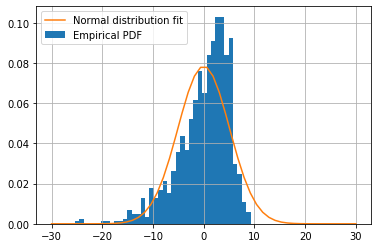

In [97]:
# PDF
plt.figure()
plt.hist(err, bins=40, density=True, label='Empirical PDF')
# comparison with Normal distribution
pdfx = np.linspace(-30,30)
ppdf = sst.norm.pdf(pdfx, scale=stdev)
plt.plot(pdfx, ppdf, label='Normal distribution fit')
plt.legend()
plt.grid()
plt.show()

<h3>Incorporating Large-scale fading into the prediction</h3>



In [98]:
def ecdf(data, normalize=-999.0):
    '''
    generates CDF from empirical data 
    data - empirical data as a numpy vector
    normalize - percentil (%) to set zero (no normalization if outside <0,100>)
    returns - (x, y) vectors in tuple    
    '''
    x = np.sort(data)
    if 0 <= normalize <= 100.0: 
        x -= np.percentile(data, normalize)
    y = np.arange(1, len(x)+1)/float(len(x))
    return (x, y)

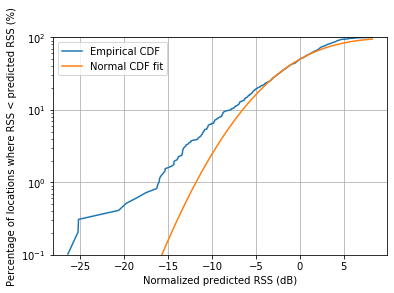

In [99]:
plt.figure()
xcdf, ycdf = ecdf(err, 50)
plt.semilogy(xcdf, 100*ycdf, label='Empirical CDF')
plt.semilogy(xcdf,100*sst.norm.cdf(xcdf,scale=stdev), label='Normal CDF fit')
plt.ylim(0.1,100)
plt.xlabel('Normalized predicted RSS (dB)')
plt.ylabel('Percentage of locations where RSS < predicted RSS (%)')
plt.legend()
plt.grid()
plt.show()

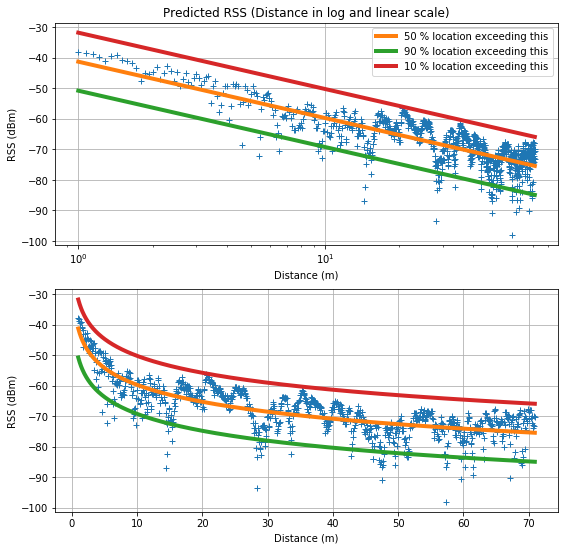

In [100]:
Pn = 20
plt.figure(figsize=(9, 9))
plt.subplot(211)
plt.semilogx(d, Pn-L, '+')
plt.plot(d, Pn-Lp, lw =4, label='50 % location exceeding this' )
plt.plot(d, Pn-Lp-9.5, lw =4, label='90 % location exceeding this' )
plt.plot(d, Pn-Lp+9.5, lw =4, label='10 % location exceeding this' )
plt.xlabel('Distance (m)')
plt.ylabel('RSS (dBm)')
plt.title('Predicted RSS (Distance in log and linear scale)')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(d, Pn-L, '+')
plt.plot(d, Pn-Lp, lw =4, label='50 % location exceeding this' )
plt.plot(d, Pn-Lp-9.5, lw =4, label='90 % location exceeding this' )
plt.plot(d, Pn-Lp+9.5, lw =4, label='10 % location exceeding this' )
plt.xlabel('Distance (m)')
plt.ylabel('RSS (dBm)')
plt.grid()
plt.show()


<h2>II. Small-scale fading statistics</h2>

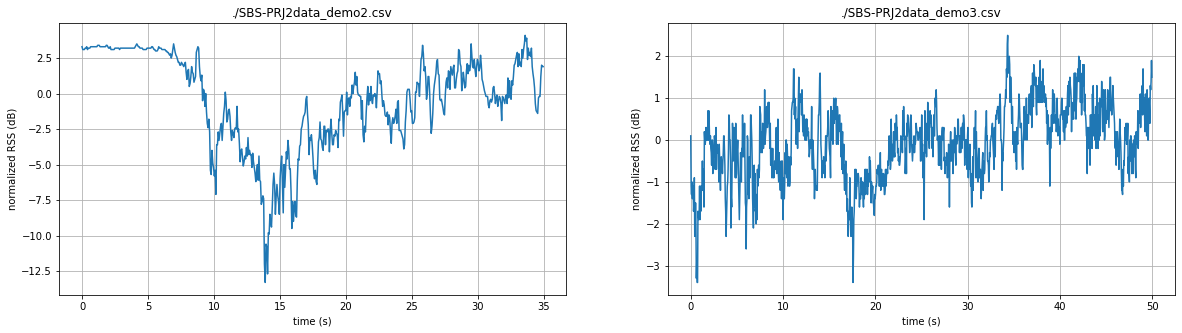

In [101]:
# Reading raw measurement data 
fig, axs = plt.subplots(1, len(raw_data_II_rx), figsize=(20, 5))
Rx = []
t = []
for i, f in enumerate(raw_data_II_rx):
    Rx.append([])
    with open(f) as ff:
        for line in ff.read().split(): # each line = 1601 readings from the PR100 receiver screen                    
            Rx[i].append(max([float(x) for x in line.split(';')])) # extracting RX value from raw data as a maximum value of each sweep screen     
    Rx[i] = Rx[i] - np.median(Rx[i])
    t.append(np.arange(0, raw_data_II_t[i], raw_data_II_t[i]/len(Rx[i])))
    axs[i].plot(t[i], Rx[i])
    axs[i].set(xlabel='time (s)', ylabel='normalized RSS (dB)', title=raw_data_II_rx[i])
    axs[i].grid()
plt.show()

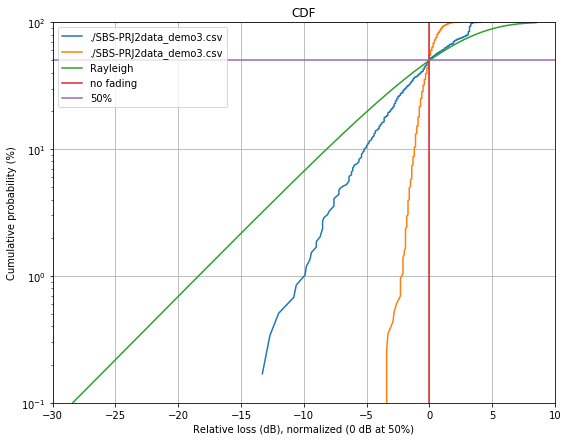

In [102]:
plt.figure(figsize=(9, 7))
for rx in Rx:
    xcdf, ycdf = ecdf(rx, 50)
    plt.semilogy(xcdf, 100*ycdf, label=raw_data_II_rx[i])
#xr = np.arange(np.power(10.0, xcdf.min()/20), np.power(10.0, (xcdf.max()+3)/20), 0.1)
xr = np.arange(np.power(10.0, -30/20), np.power(10.0, 10/20), 0.1)
yr = sst.rayleigh.cdf(xr)
xr = 20.0*np.log10(xr/sst.rayleigh.median())
plt.semilogy(xr,100*yr, label='Rayleigh')
plt.plot([0,0],[0.01,100], label='no fading')
plt.plot([-30,10],[50,50], label='50%')
plt.ylim(0.1,100)
plt.xlim(-30,10)
plt.xlabel('Relative loss (dB), normalized (0 dB at 50%)')
plt.ylabel('Cumulative probability (%)')
plt.title('CDF')
plt.legend()
plt.grid()
plt.show()